<a href="https://colab.research.google.com/github/DRO-Physics/DL-and-ML-for-Medical-Physics/blob/main/DL_Model_HongQiTan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Pathological Complete Response of Neo-adjuvant Chemotherapy in Breast Cancer using CT data

Neo-adjuvant chemotherapy plays the role of down-staging the tumor before surgery so that the breast can be preserved as much as possible. A pathological complete response (pathCR) implies a full downstaging of tumor to T0N0 (as good as complete curation of the tumor). The event rate of pathCR in a typical Breast Cancer cohort is 20%. However, current clinical predictors with HER2, ER and PR status only achieve an AUC of about 0.70 for pathCR prediction; it is hard to determine *a priori* which patient will benefit from Neo-adjuvant chemotherapy. If we can determine with greater accuracy which patient will not benefit from Neoadjuvant chemotherapy, time will not be wasted on the treatment and surgery can be performed earlier before tumor become more aggressive. The role of this project is to determine if Deep Learning on CT data can value-add to the current clinical predictors and enhance the AUC. 

Hong-Qi Tan



In [ ]:
import os
import glob 
import nrrd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from datetime import datetime

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
from tensorflow.keras.callbacks import LambdaCallback, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import tensorflow as tf

## for tensorboard
%load_ext tensorboard

In [ ]:
## Check tf and keras version
print(tf.keras.__version__)
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)



2.4.0
2.4.0


In [ ]:
!nvidia-smi

Wed Dec 30 10:26:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:3B:00.0  On |                  N/A |
| 28%   35C    P8    15W / 250W |    297MiB / 11016MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:AF:00.0 Off |                  N/A |
| 27%   

In [ ]:
## defining inputs
BASE_DIR = '.'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

In [ ]:
## Define DL parameters
batch_size = 2
num_classes = 2
epochs = 200
learning_rate = 0.001

width, height, depth = 128, 128, 64
input_shape = (width, height, depth, 1) ## Last one for channel!

In [ ]:
def ReadAndConditionData(fname): 
    data = nrrd.read(fname)[0]
    size = np.shape(data)
    data = zoom(data, zoom = (width*1.0 / size[0], (height*1.0 / size[1]), (depth*1.0) / size[2] ))
    data = (data - np.mean(data)) / np.std(data)
    return data

In [ ]:
## Read in image and massage!!
x_train = []
x_valid = []
x_test = []
y_train = []
y_valid = []
y_test = []
info = pd.read_csv('DL_information.csv')
for k in range(len(info['nric'])):
    fname = info['nric'].loc[k]
    split = info['split_new'].loc[k]
    if split == 1: 
        data = ReadAndConditionData(os.path.join(TRAIN_DIR, fname + '.nrrd'))
#         print(data)
        x_train.append(data)
        y_train.append(info['target'].loc[k])
    elif split == 2: 
        data = ReadAndConditionData(os.path.join(VALID_DIR, fname + '.nrrd'))
        x_valid.append(data)
        y_valid.append(info['target'].loc[k])
    elif split == 0: 
        data = ReadAndConditionData(os.path.join(TEST_DIR, fname + '.nrrd'))
        x_test.append(data)
        y_test.append(info['target'].loc[k])
    print(k)
        
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_valid = np.asarray(y_valid)
y_test = np.array(y_test)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
## For categorical data
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)


In [ ]:
# y_train = y_train[:,1]
# y_valid = y_valid[:,1]
# y_test = y_test[:,1]
# x_train = np.expand_dims(x_train, axis=4)
# x_valid = np.expand_dims(x_valid, axis=4)
# x_test = np.expand_dims(x_test, axis=4)


In [ ]:
# x_train = np.reshape(x_train, (130,128,128,64))
# x_valid = np.reshape(x_valid, (43,128,128,64))
# x_test = np.reshape(x_test, (150,128,128,64))
print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_valid), np.shape(y_valid))
print(np.shape(x_test), np.shape(y_test))

(123, 128, 128, 64) (123,)
(50, 128, 128, 64) (50,)
(150, 128, 128, 64) (150,)


In [ ]:
## Data Augmentation
from scipy import ndimage

@tf.function
def image_augmentation(image):
    def scipy_rotate(image):
        ## Add Noise
#         print(np.shape(image))
        # define some rotation angles
        angle = np.random.uniform(-10,10)
        # rotate volume
        volume = ndimage.rotate(image, angle, reshape=False)
#         volume = volume + np.random.normal(0, 0.005)
        # volume[volume < 0] = 0
        # volume[volume > 1] = 1 ## Only use this if using min-max normalization
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [image], tf.float32)
#     label = tf.one_hot(label, num_classes)
    return augmented_volume

def train_preprocessing(volume, label):
    volume = image_augmentation(volume)
    volume = tf.expand_dims(volume, axis = 0) ## 3 for channel last
    return (volume, label)

def valid_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis = 0) ## 3 for channel last
    return (volume, label)


In [ ]:
## Define tf dataset
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

train_dataset = train_loader.shuffle(len(x_train)).map(train_preprocessing)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
# train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).prefetch(4)

valid_dataset = validation_loader.shuffle(len(x_valid)).map(valid_preprocessing)
valid_dataset = valid_dataset.apply(tf.data.experimental.ignore_errors())
# valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True).prefetch(4)

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 14, 64)    256   

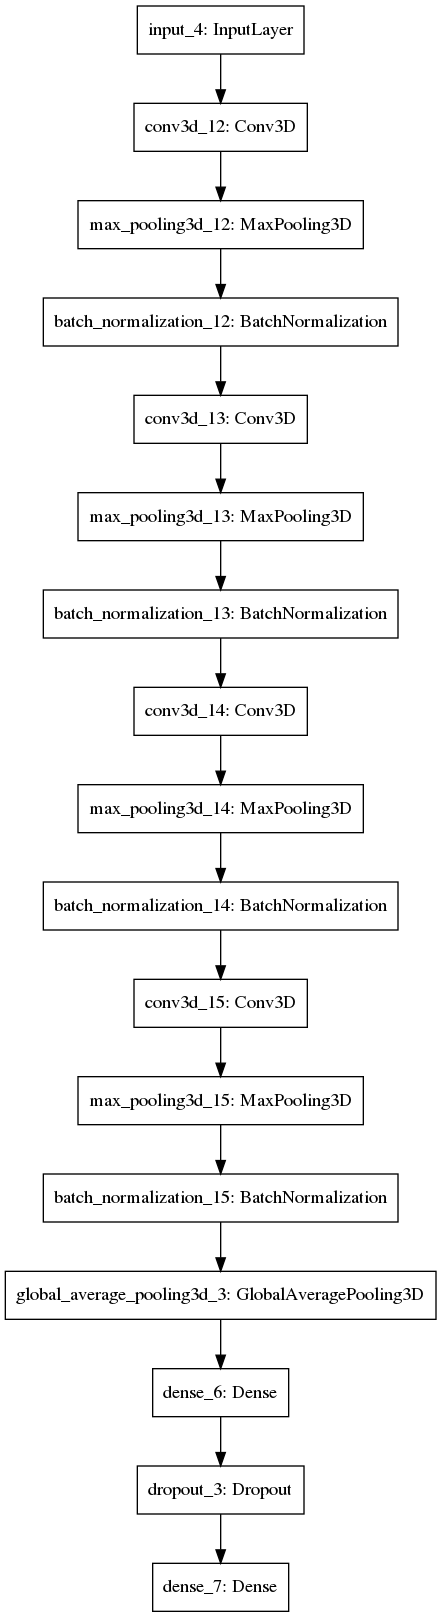

In [ ]:
### This is the first attempt of training a DL model from scratch. 
## Defining Model
inputs = Input(input_shape)
x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
x = MaxPool3D(pool_size=2)(x)
x = BatchNormalization()(x)

x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPool3D(pool_size=2)(x)
x = BatchNormalization()(x)

x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPool3D(pool_size=2)(x)
x = BatchNormalization()(x)

x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
x = MaxPool3D(pool_size=2)(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling3D()(x)
x = Dense(units=512, activation="relu")(x)
x = Dropout(0.3)(x)

outputs = Dense(units=1, activation="sigmoid")(x)

# Define the model.
model = Model(inputs, outputs, name="3dcnn")

model.summary()

plot_model(model, to_file='MyModel.png')

In [ ]:
### This is a second attempt of creating a model using transfer learning on model from 
# https://github.com/MrGiovanni/ModelsGenesis
## Transfer Learning on Model Genesis
import unet3d

weight_dir = './Model_Genesis/Genesis_Chest_CT.h5'
inputs = Input((1, 128, 128, 64))
base_model = unet3d.unet_model_3d((1, 128, 128, 64), batch_normalization=True)
base_model.load_weights(weight_dir)
for k, layer in enumerate(base_model.layers): 
    if k < 25:
        layer.trainable = False
x = base_model.get_layer('depth_7_relu').output
x = Dropout(0.3)(x)
x = GlobalAveragePooling3D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, output, name = 'TL_on_Genesis')
model.summary()

for layer in model.layers: 
    print('Trainable %s : %d' %(layer.name, layer.trainable))
# plot_model(model, to_file='MyModel.png')

Model: "TL_on_Genesis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 128, 128, 64)] 0         
_________________________________________________________________
depth_0_conv (Conv3D)        (None, 32, 128, 128, 64)  896       
_________________________________________________________________
depth_0_bn (BatchNormalizati (None, 32, 128, 128, 64)  128       
_________________________________________________________________
depth_0_relu (Activation)    (None, 32, 128, 128, 64)  0         
_________________________________________________________________
depth_1_conv (Conv3D)        (None, 64, 128, 128, 64)  55360     
_________________________________________________________________
depth_1_bn (BatchNormalizati (None, 64, 128, 128, 64)  256       
_________________________________________________________________
depth_1_relu (Activation)    (None, 64, 128, 128, 64)

In [ ]:
## Defining Checkpoints and Callbacks!
# Save the best weight!
checkpoint1 = ModelCheckpoint('./checkpoints/best_weights_auc.h5', monitor='val_auc', verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint('./checkpoints/best_weights_precision.h5', monitor='val_precision', verbose=1, save_best_only=True, mode='max')
checkpoint3 = ModelCheckpoint('./checkpoints/best_weights_acc.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint4 = ModelCheckpoint('./checkpoints/best_weights_recall.h5', monitor='val_recall', verbose=1, save_best_only=True, mode='max')

## Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=30,verbose=0,mode='auto')
## CSV Logger
csv = CSVLogger('training_stats.csv', separator=',', append=False)
## LR schedular
reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.9, patience=10,cooldown=0, min_lr = 0.00001)

## Tensorboard
logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the basic TensorBoard callback for logging the scalars etc
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)



In [ ]:
### Compile Model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])




In [ ]:
## Train the Model
K.set_value(model.optimizer.lr, 0.001)

history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=epochs,
                    verbose=2,
                    class_weight = {0:1, 1:5},
                    shuffle=True,
                    callbacks = [checkpoint1, checkpoint2, checkpoint3, checkpoint4, csv, early_stopping, reduce_LR])

Epoch 1/200
61/61 - 22s - loss: 1.2483 - accuracy: 0.6885 - auc: 0.7719 - precision: 0.3962 - recall: 0.7778 - val_loss: 1.2693 - val_accuracy: 0.5400 - val_auc: 0.6675 - val_precision: 0.2593 - val_recall: 0.7000

Epoch 00001: val_auc improved from -inf to 0.66750, saving model to ./checkpoints/best_weights_auc.h5

Epoch 00001: val_precision improved from -inf to 0.25926, saving model to ./checkpoints/best_weights_precision.h5

Epoch 00001: val_accuracy improved from -inf to 0.54000, saving model to ./checkpoints/best_weights_acc.h5

Epoch 00001: val_recall improved from -inf to 0.70000, saving model to ./checkpoints/best_weights_recall.h5
Epoch 2/200
61/61 - 19s - loss: 0.8175 - accuracy: 0.7541 - auc: 0.8879 - precision: 0.4694 - recall: 0.8519 - val_loss: 0.9491 - val_accuracy: 0.7800 - val_auc: 0.6362 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_auc did not improve from 0.66750

Epoch 00002: val_precision did not improve from 0.25926

Epoch 00002: val_acc


Epoch 00018: val_auc did not improve from 0.75125

Epoch 00018: val_precision did not improve from 0.57143

Epoch 00018: val_accuracy did not improve from 0.82000

Epoch 00018: val_recall did not improve from 1.00000
Epoch 19/200
61/61 - 20s - loss: 0.6297 - accuracy: 0.7951 - auc: 0.9226 - precision: 0.5217 - recall: 0.8889 - val_loss: 0.6856 - val_accuracy: 0.8600 - val_auc: 0.6787 - val_precision: 0.8000 - val_recall: 0.4000

Epoch 00019: val_auc did not improve from 0.75125

Epoch 00019: val_precision improved from 0.57143 to 0.80000, saving model to ./checkpoints/best_weights_precision.h5

Epoch 00019: val_accuracy improved from 0.82000 to 0.86000, saving model to ./checkpoints/best_weights_acc.h5

Epoch 00019: val_recall did not improve from 1.00000
Epoch 20/200
61/61 - 20s - loss: 0.8197 - accuracy: 0.7623 - auc: 0.8834 - precision: 0.4783 - recall: 0.8148 - val_loss: 1.9586 - val_accuracy: 0.8000 - val_auc: 0.5387 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 000

Epoch 37/200
61/61 - 19s - loss: 0.4086 - accuracy: 0.9016 - auc: 0.9694 - precision: 0.7143 - recall: 0.9259 - val_loss: 0.9805 - val_accuracy: 0.8200 - val_auc: 0.7400 - val_precision: 1.0000 - val_recall: 0.1000

Epoch 00037: val_auc did not improve from 0.75125

Epoch 00037: val_precision did not improve from 1.00000

Epoch 00037: val_accuracy did not improve from 0.86000

Epoch 00037: val_recall did not improve from 1.00000
Epoch 38/200
61/61 - 19s - loss: 0.6454 - accuracy: 0.7951 - auc: 0.9191 - precision: 0.5217 - recall: 0.8889 - val_loss: 1.9097 - val_accuracy: 0.8000 - val_auc: 0.5500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00038: val_auc did not improve from 0.75125

Epoch 00038: val_precision did not improve from 1.00000

Epoch 00038: val_accuracy did not improve from 0.86000

Epoch 00038: val_recall did not improve from 1.00000
Epoch 39/200
61/61 - 19s - loss: 0.7643 - accuracy: 0.7951 - auc: 0.9142 - precision: 0.5227 - recall: 0.8519 - val_loss: 0.74

Epoch 56/200
61/61 - 17s - loss: 0.3266 - accuracy: 0.9098 - auc: 0.9756 - precision: 0.7105 - recall: 1.0000 - val_loss: 1.2054 - val_accuracy: 0.8200 - val_auc: 0.5750 - val_precision: 1.0000 - val_recall: 0.1000

Epoch 00056: val_auc did not improve from 0.75125

Epoch 00056: val_precision did not improve from 1.00000

Epoch 00056: val_accuracy did not improve from 0.86000

Epoch 00056: val_recall did not improve from 1.00000
Epoch 57/200
61/61 - 19s - loss: 0.6255 - accuracy: 0.8115 - auc: 0.9355 - precision: 0.5455 - recall: 0.8889 - val_loss: 2.4470 - val_accuracy: 0.8000 - val_auc: 0.5500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00057: val_auc did not improve from 0.75125

Epoch 00057: val_precision did not improve from 1.00000

Epoch 00057: val_accuracy did not improve from 0.86000

Epoch 00057: val_recall did not improve from 1.00000
Epoch 58/200
61/61 - 20s - loss: 0.3634 - accuracy: 0.8770 - auc: 0.9758 - precision: 0.6579 - recall: 0.9259 - val_loss: 2.02

Epoch 75/200
61/61 - 19s - loss: 0.3189 - accuracy: 0.9180 - auc: 0.9848 - precision: 0.7353 - recall: 0.9615 - val_loss: 1.7411 - val_accuracy: 0.4000 - val_auc: 0.7025 - val_precision: 0.2059 - val_recall: 0.7000

Epoch 00075: val_auc did not improve from 0.75125

Epoch 00075: val_precision did not improve from 1.00000

Epoch 00075: val_accuracy did not improve from 0.86000

Epoch 00075: val_recall did not improve from 1.00000
Epoch 76/200
61/61 - 19s - loss: 0.3880 - accuracy: 0.8607 - auc: 0.9742 - precision: 0.6098 - recall: 0.9615 - val_loss: 0.7930 - val_accuracy: 0.8600 - val_auc: 0.7225 - val_precision: 1.0000 - val_recall: 0.3000

Epoch 00076: val_auc did not improve from 0.75125

Epoch 00076: val_precision did not improve from 1.00000

Epoch 00076: val_accuracy did not improve from 0.86000

Epoch 00076: val_recall did not improve from 1.00000
Epoch 77/200
61/61 - 19s - loss: 0.3154 - accuracy: 0.9344 - auc: 0.9844 - precision: 0.8276 - recall: 0.8889 - val_loss: 4.6251 - val

In [ ]:
## Start tensorboard
%tensorboard --logdir logs/image 

In [ ]:
def plot_ROC(y_actual, y_prob, label_set):
    ## Configure bootstrap
    mean_score, ci_lower, ci_upper, scores = stat_util.score_stat_ci(y_actual, y_prob, score_fun=roc_auc_score, stat_fun=np.mean)
    fpr, tpr, _ = roc_curve(y_actual, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(0, figsize=(9,10))
    plt.plot(fpr, tpr, color=None, Linewidth=3, label = '{} = {:0.3f} ({:0.3f} to {:0.3f})'.format(label_set, roc_auc, ci_lower, ci_upper))
    plt.legend()

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


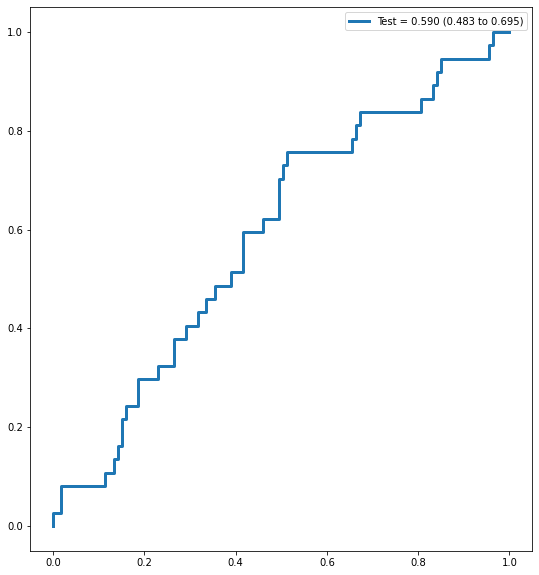

In [ ]:
### Apply prediction
import stat_util
from sklearn.metrics import roc_auc_score, roc_curve, auc, brier_score_loss

model.load_weights("./checkpoints/best_weights_auc.h5")
test_pred = []
for k in range(len(y_test)): 
    pred = model.predict(np.expand_dims(np.expand_dims(x_test[k],axis=0),axis=0))[0][0]
    test_pred.append(pred)
#     print(pred)

np.savetxt('Prob_train_pred.txt', test_pred)
# np.savetxt('Target_test.txt', y_test)
# print(y_test, test_pred)
plot_ROC(y_test, test_pred, 'Test')



This is the best AUC results I have gotten with the CT data set using Deep Learning.

In [ ]:
## This function is to visualize the class activation map. It is adapted from https://keras.io/api/metrics/classification_metrics/#auc-class
## and modified to be compatible with our 3d images

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)
    print(np.shape(img_array))

#     # Then, we compute the gradient of the top predicted class for our input image
#     # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        print(top_class_channel)

#     # This is the gradient of the top predicted class with regard to
#     # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

#     # This is a vector where each entry is the mean intensity of the gradient
#     # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 2, 3, 4))

#     # We multiply each channel in the feature map array
#     # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[i, :, :, :] *= pooled_grads[i]

#     # The channel-wise mean of the resulting feature map
#     # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=0)

#     # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
import matplotlib.cm as cm

index = 58
## Run Gradcam
image = np.expand_dims(np.expand_dims(x_test[index],axis=0),axis=0)
# print(image)
heatmap = make_gradcam_heatmap(image, model,'depth_7_relu', ['global_average_pooling3d', 'dense', 'dense_1'])
print(y_test[index])
## Load Image again
img = x_test[index]


(1, 1, 128, 128, 64)
tf.Tensor([0.98295605], shape=(1,), dtype=float32)
1


In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

def PlotHeatmap(x): 
    width, height, depth = np.shape(img)
    heatmap_slice = zoom(heatmap, zoom = (width*1.0 / 16, (height*1.0 / 16), (depth*1.0) / 8 ))
    plt.imshow(np.transpose(img[:,:,x]), cmap='bone')
    plt.imshow(np.transpose(heatmap_slice[:,:,x]), cmap='jet', alpha = 0.4)
    plt.savefig('Patient4.png')
    plt.show()
    


In [ ]:
interact(PlotHeatmap, x=widgets.IntSlider(min=0, max=63, step=2, value=18))

interactive(children=(IntSlider(value=18, description='x', max=63, step=2), Output()), _dom_classes=('widget-i…

<function __main__.PlotHeatmap(x)>